# Testing memory transfer between Imaris and Python
This notebook highlights the difference between transfering 8 bit and 16 bit datasets, from Imaris to Python and vice versa.

**Edit:** As of Imaris 9.2.0, here's the score on my test dataset (2688x2200x131 stack, Windows 8.1 64 bit, E5-2650 v4, 32GB RAM). This includes added array conversion when sending volume data from Python to Imaris.

|          |Imaris → Python|Python → Imaris|
|----------|---------------|---------------|
| **8 bit**|5s             |9s             |
|**16 bit**|115s           |15s            |

In [1]:
%load_ext autoreload
%autoreload 2

%reload_ext XTIPython

You can now access BridgeLib, ImarisLib, vImaris, vDataSet, vScene and vFactory


In [15]:
vImaris.GetVersion()

'Imaris x64 9.2.0 [May 28 2018]'

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

## For info, this is what the dataset looks like (fly embryo).

Original dataset is 16 bit, reduced to 8 bit using FIJI

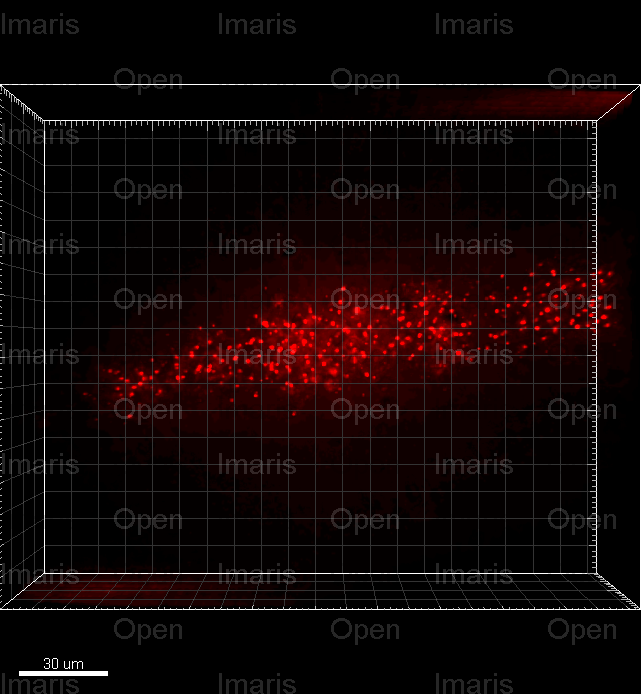

In [3]:
%imaris_screenshot

## 8 bit transfer

In [4]:
nx = vDataSet.GetSizeX()
ny = vDataSet.GetSizeY()
nz = vDataSet.GetSizeZ()
dtype = BridgeLib.GetType(vDataSet)

print nz,ny,nx,dtype

131 2200 2688 <type 'numpy.uint8'>


### Let's fetch the data volume and check how long it takes

In [5]:
import time
t = time.time()
arr = BridgeLib.GetDataVolume(vDataSet,0,0)
print "Operation took %.1fs"%(time.time()-t),arr.shape,arr.dtype

Operation took 4.4s (131L, 2200L, 2688L) uint8


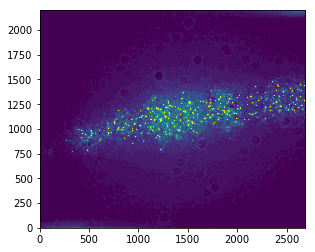

In [6]:
vmin,vmax = vDataSet.GetChannelRangeMin(0),vDataSet.GetChannelRangeMax(0)
p = plt.imshow(np.max(arr,axis=0),origin='lower',vmin=vmin,vmax=vmax)

### This next step tests type conversion in BridgeLib.SetDataVolume()
BridgeLib.SetDataVolume() automatically handles type conversion, so here we're converting the dataset array to float32 first, then sending it back to Imaris.

In [7]:
arr = arr.astype(np.float32)

In [8]:
vDataSet.SetSizeC(2)
t = time.time()
BridgeLib.SetDataVolume(vDataSet,arr,1,0)
print "Operation took %.1fs"%(time.time()-t)

Operation took 8.9s


## Testing data transfer with a 16 bit dataset

### Motivation:
For 8 bit data, we can just grab the volume data into Python using GetDataVolumeAs1DArrayBytes() / numpy.frombuffer() and the operation is quite fast.

For 16 bit datasets however, fetching the volume array in one go doesn't seem to be possible. On three different machines I tested this on, 32GB of RAM wasn't enough and Imaris just hung with all the RAM taken up.

The next best thing when fetching data from Imaris is to reconstruct the 3-D array slice by slice (in the Z direction) using vDataSet.GetDataSubVolumeAs1DArrayShorts (or vDataSet.GetDataSubVolumeAs1DArrayFloats for 32 bit data).

### At this point, the 16 bit dataset was loaded in Imaris.

In [9]:
%imaris_sync

You can now access BridgeLib, ImarisLib, vImaris, vDataSet, vScene and vFactory


In [10]:
nx = vDataSet.GetSizeX()
ny = vDataSet.GetSizeY()
nz = vDataSet.GetSizeZ()
dtype = BridgeLib.GetType(vDataSet)

print nz,ny,nx,dtype

131 2200 2688 <type 'numpy.uint16'>


### Let's fetch the data volume and check how long it takes

In [11]:
import time
t = time.time()
arr = BridgeLib.GetDataVolume(vDataSet,0,0)
print "Operation took %.1fs"%(time.time()-t),arr.shape,arr.dtype

Operation took 114.2s (131L, 2200L, 2688L) uint16


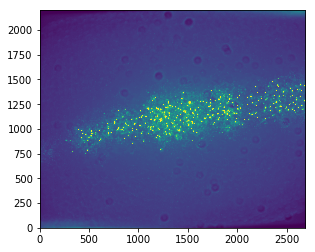

In [12]:
vmin,vmax = vDataSet.GetChannelRangeMin(0),vDataSet.GetChannelRangeMax(0)
p = plt.imshow(np.max(arr,axis=0),origin='lower',vmin=vmin,vmax=vmax)

### This next step tests type conversion in BridgeLib.SetDataVolume()
BridgeLib.SetDataVolume() automatically handles type conversion, so here we're converting the dataset array to float32 first, then sending it back to Imaris.

In [13]:
arr = arr.astype(np.float32)

In [14]:
vDataSet.SetSizeC(2)
t = time.time()
BridgeLib.SetDataVolume(vDataSet,arr,1,0)
print "Operation took %.1fs"%(time.time()-t)

Operation took 14.6s
